In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
pathlist = Path(path).glob('*.csv')
sparks_data_list = []
for file in pathlist:
    path_in_str = str(file)
    df = pd.read_csv(path_in_str)
    sparks_data_list.append(df)
sparks_data_list = pd.concat(sparks_data_list)
del (sparks_data_list['Unnamed: 0'])
del (sparks_data_list['minim'])
del (sparks_data_list['FWHM'])
del (sparks_data_list['pos_x'])
del (sparks_data_list['pos_y'])
del (sparks_data_list['FDHM'])
del (sparks_data_list['full_width'])
del (sparks_data_list['sparks_tiempo_pico50_2'])
del (sparks_data_list['tiempo_minimo'])

In [4]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [5]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

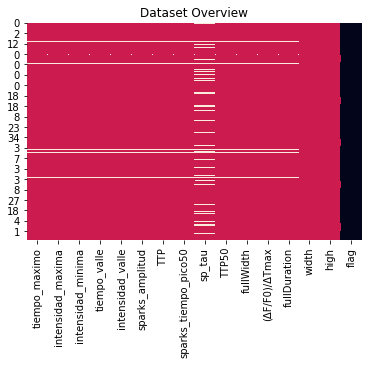

 Categerocial   Numeric   NaN 


In [6]:
dic_cols = {col:utils_recognize_type(sparks_data_list, col, max_cat=20) for col in sparks_data_list.columns}
heatmap = sparks_data_list.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [7]:
dtf = sparks_data_list
dtf = dtf.rename(columns={"flag":"Y"})

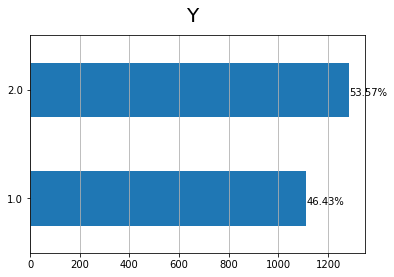

In [8]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

In [19]:
cat, num = "Y", "fullDuration"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.246)


In [14]:
x, y = "fullDuration", "Y"
cont_table = pd.crosstab(index=dtf[x], columns=dtf[y])
chi2_test = scipy.stats.chi2_contingency(cont_table)
chi2, p = chi2_test[0], chi2_test[1]
n = cont_table.sum().sum()
phi2 = chi2/n
r,k = cont_table.shape
phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
rcorr = r-((r-1)**2)/(n-1)
kcorr = k-((k-1)**2)/(n-1)
coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")

Cramer Correlation: 0.146 Significant (p-value:0.0)


In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
from PIL import Image